## Homework 2 : Clustering Gaussian Mixtures



**Reminder:** This time we will penalize excessively long answers, i.e. if you cannot answer a question with 1-5 sentences, you should think again.


In this homework you will perform Gibbs sampling on a Gaussian Mixture Model (GMM). You will compute the posterior distribution of a general Gaussian Mixture, generate data from it (a ground truth), sample the equilibrium distribution through Gibbs sampling and check if the retrieved model resembles the original one that truly generated your data.

In [1]:
#Import the necessary packages. You may want to import other ones if needed.
from sklearn.mixture import GaussianMixture as GMM
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
np.random.seed(42)

## Exercise 1 (6 pt) - Theory Questions

In this first part we will recall concepts dealt in class and in the notes of the course, with small variations. Please refer to Chapter $8.1$ of the lecture notes for the full details on Clustering and the setting below.

Consider a set $X \in \mathbb{R}^{n \times d}$ of unlabelled data, i.e., a set of $n \in \mathbb{N}$ objects with $d \in \mathbb{N}$ features respectively.

The Loss function that a Gaussian Mixture Model (GMM) aims at minimizing is the following:
$$
    \mathcal{L}(U,V) := \frac{1}{n}\sum_{\mu=1}^n\sum_{i=1}^d \left( X_{\mu i } - \sum_{a=1}^k u_{a i} v_{\mu a} \right)^2
$$

where the vectors $v_\mu \in \mathbb{R}^k$ are the one-hot encoded representations of the clustering assignment of points, and $u_a \in \mathbb{R}^d$ are coordinates of the cluster centers.

The size of the clusters is encoded in the prior of the label assignments:

$$P_{v}(V) = \prod_{\mu=1}^n P_{v}(v_\mu) = \prod_{\mu=1}^n \left( \sum_{a=1}^k \pi_a\delta(e_a - v_\mu) \right)$$

where $\sum_a \pi_a = 1 $ ($\pi_a \in (0,1)$ are the fractions corresponding to the size of cluster $a$ and they are called weights and $e_a$ is a one-hot encoded vector of size $k$ which takes value 1 at the position $a$ and zero elsewhere).




In this setting, the important parameters that define our model are the cluster centers, the cluster assignments and the weights of each cluster. All these informations are encoded in the class GaussianMixture of the library sklearn, that is imported above.

**Question 1 (1 pt):** You are given an histogram of $n=4600$ points generated with 3 Gaussian distributions in $d=1$ dimensions. For this first question, create a Gaussian Mixture Model (GMM) from the package GMM and fit the points of the histogram.

Replot the histogram of raw points along with the fitted curve (GMM) and print the fitted values of the weights, the means and the covariances of the Gaussians found by the model.

Remark: in k-means and in GMM you have to specify the number of clusters.

(-10.0, 20.0)

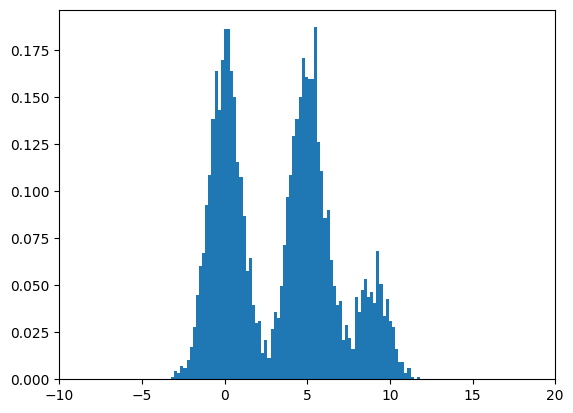

In [2]:
x = np.concatenate([np.random.normal(0, 1, 2000),
                    np.random.normal(5, 1, 2000),
                    np.random.normal(9, 1, 600)])     # concatenates the three gaussian-distributed vectors
x=x.reshape(-1,1)

plt.hist(x, 80, density=True)                          # density=True normalizes the histogram
plt.xlim(-10, 20)


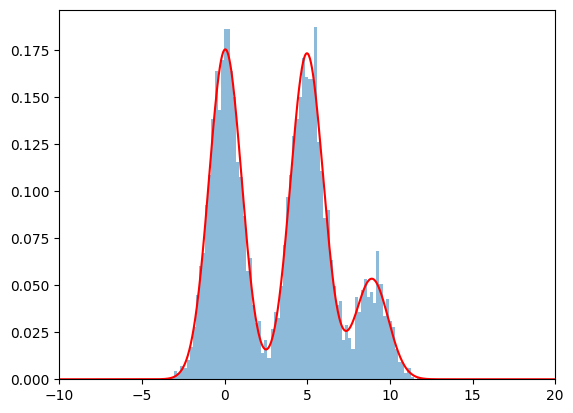

(array([0.43326164, 0.13205806, 0.4346803 ]),
 array([[4.98336285],
        [8.9093236 ],
        [0.04511381]]),
 array([[[0.99493571]],
 
        [[0.97292019]],
 
        [[0.97745714]]]))

In [3]:
### Insert your code here

#Here we fit the gaussian mixture with the hisogram
gmm = GMM(n_components=3, random_state=42)
gmm.fit(x)

# We then extract the fitted parameters
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

# We plot again the histogram of the data
plt.hist(x, 80, density=True, alpha=0.5)
plt.xlim(-10, 20)

# Then we plot the fitted Gaussian distributions
x_axis = np.linspace(-10, 20, 1000).reshape(-1, 1)
logprob = gmm.score_samples(x_axis)
pdf = np.exp(logprob)
plt.plot(x_axis, pdf, color='red')
plt.show()

# Finally we print the fitted values
weights, means, covariances


Note: for practical purposes you will use the function GMM. However, for the purpose of this homework you will have to write from scratch the functions needed in the following.

Now consider the following framework for generating synthetic data:

\begin{equation}
X_{\mu i} = \sqrt{\frac{\rho}{d}} \sum_{a=1}^k v^{*}_{\mu a} u^{*}_{ai} + \xi_\mu
\end{equation}

where $v^{*}_{\mu}$ is the ground-truth one-hot vector, encoding the cluster memberships of data-point $X_{\mu}$, while $u^{*}_{a}$ is the ground-truth centre of cluster $a$.
The additional term $ \xi_{\mu i} \sim \mathcal{N}(0,1)$ corresponds to the noise, here assumed to be the same for all clusters ($V \in \mathbb{R}^{n\times k}$, $U\in \mathbb{R}^{k\times d}$ and $\xi \in \mathbb{R}^{n \times d}$ are matrices!) . The factor $\frac{1}{\sqrt{d}}$ corresponds to the scaling for which the model behaves interestingly.

The parameter $\rho>0$ is called "signal-to-noise ratio" and indicates the relative fraction of the information you want to retrieve, in this case the cluster centers and the label assignment, with respect to the noise through which your data are corrupted.

The goal of the excercise is to infer the ground-truth,  that is the cluster centers $U^*$ and the cluster assignment of points $V^*$, given the noisy observations $X_{\mu i} $. We do it in a Bayesian setting.

**Question 2 (1 pt):** What do you expect to happen to the inference problem, i.e. recovering the true centres of clusters and the true labels of points, when $\rho$ is very small ? What do you expect to happen when $\rho$ is very large? What could happen for intermediate values of $\rho$ if the number of data and dimensions become very large and of comparable sizes, in particular $d,n\rightarrow \infty$ with $\alpha=n/d=o(1)$.

_Answer_ :  
$\rho$ is small : no information are recoverable since the noise is greater than the signal itself. $X_{\mu i}$ becomes completly random and can not be assigned to a certain cluster.  
$\rho$ is large : The noise becomes negligeable, $X_{\mu i}$ tends to overlap with the center of their cluster and recovering ground truth and cluster assignment becomes trivial.  
 $\rho$ intermediate : $\alpha=n/d=o(1)$, inference quality depedns on the amount of data and the separation of clusters is now related to the noise.

**Question 3 (2 pt):** Write the posterior distribution of the model. What is the value of the temperature $\Delta$ (recall lecture notes) here ?

Remark:In this first point the priors for the rows for each cluster $u_i \in \mathbb{R}^d$ are i.i.d., i.e. factorized over $i=1,...,d$ with a given as $P_{u}(u_i)$.

Similarly the label assignments $v_\mu \in \mathbb{R}^k$ are i.i.d. over $\mu=1,...,n$ and we use the general prior $P_{v}(v_\mu)$.

This leads to the posterior

_Answer_ :
$P(U, V \mid X ) =  \dfrac{1}{Z}P(U) P(V) \prod_{\mu=1}^{n} \prod_{i=1}^{d} \exp\left(-\frac{1}{2\sigma} \left(X_{\mu i} - \sqrt{\frac{\rho}{d}} \sum_{a=1}^k u_{ai} v_{\mu a} \right)^2 \right)$  


Where $Z$ is the normalization, $\Delta=\sigma=Temperature=1$ since $ \xi_{\mu i} \sim \mathcal{N}(0,1)$. In notes, we defined $\sigma$ (not $\sigma^2$) as the variance of the noise in the data and by definition, the temperature $\Delta$ is equal to this quantity. See paragraph 7.2.1 Analogies with statistical Physics : "The noise variance $\Delta$ plays the role of temperature".

From now on, assume the distribution of the centers $u_{i}$ (for each cluster $a=1\dots k$) to be Gaussian with zero mean and unit variance. This means:
$$
P_u (u_i) = \frac{1}{(2\pi)^{k/2}}\exp(\frac{-||u_i||^{2}_{2}}{2}) = \prod_{a=1}^{k} \frac{1}{2\pi}\exp\Big(\frac{-u_{i a}^2}{2}\Big)
$$

Moreover, assume the labels are uniformly distributed, that is $\pi_{a}=\frac{1}{k}$ $\forall a$. This means:
$$
P_{v}(v_\mu) = \frac{1}{k} \left( \sum_{a=1}^k \delta(e_a - v_\mu) \right)
$$

Also assume the number of clusters k and the parameter $\rho$ are given. The only objective is to recover the matrices U and V.

**Question 4 (2 pt):** Write a function for generating GMM data in the format above, with all the assumptions on U and V. Generate the data $X_\mu$ with $n=300$ and $d=150$. Store the matrices U and V that you used for generating them as the ground-truth that you want to recover. Use $k=2$ clusters and $\rho=4$

Hint: you may want to take inspiration from the function in the Excercise session 7 but change it accordingly.





In [4]:
### Write your code here:
def generate_gmm_data(n, d, k, rho):
    ###
    # Definition of the true centers U for each cluster
    U_true = np.random.normal(0,1,(k,d))

    # Generation of the true cluster assignment V
    V_true = np.zeros((n,k))
    cluster_indices = np.random.choice(k,n,replace=True)
    V_true[np.arange(n), cluster_indices] = 1

    # Generation of datat X
    X = np.zeros((n,d))
    for mu in range(n):
        cluster_a = np.argmax(V_true[mu])
        noise = np.random.normal(0,1,d)
        X[mu]=np.sqrt(rho/d) * U_true[cluster_a] + noise  
        

    return X, U_true, V_true # X in (n,d), U in (k,d), V in (n,k)




## Exercise 2 (10 pt) - Gibbs Sampling

For now let's forget about the ground truth $U^*$ and $V^*$. Just keep in mind the data $X$ you generated and the values of $k$, $\rho$ and $d$.

The objective of this exercise is to sample from the posterior distribution identified earlier, using Gibbs sampling. Gibbs sampling is advantageous here because it adapts well to continuous variables, and simplifies the sampling process by breaking it down into scalar values through the use of conditional probabilities.

In all this setting keep in mind the posterior distribution you derived before, as well as the priors for the cluster centers and the label assignments:
$$
P_u (u_i) = \frac{1}{(2\pi)^{k/2}}\exp(\frac{-||u_i||^{2}_{2}}{2})
$$
and
$$
P_{v}(v_\mu) = \frac{1}{k} \left( \sum_{a=1}^k \delta(e_a - v_\mu) \right)
$$




**Question 1 (6 pt):** In this question we write and code the Gibbs Sampling algorithm for GMM.

Note that in this problem the matrices that you want to reconstruct, are $U$ and $V$ (instead of just a single one as in the spin glass game). For this reason, the main focus of Gibbs sampling are the **two** conditional probabilities

 $$P(u_{ai}|\{u_{a'i'}\}_{a'\neq a,i'\neq i} , V, X)$$

 and

$$P(v_{\mu a}|\{v_{\mu'a'}\}_{\mu'\neq \mu,a'\neq a} , U, X).$$

For the purpose of the derivation you will keep the notation general and then, when you will run your code, fix the values $k=2$, $d=150 $, $n=300 $, $\rho=4$


Derivation of the Gibbs sampling.

**A)** Derive the likelihood (Note, highlight only the interesting terms, i.e. the one(s) depending explicitely on $u_{ia}$ and $v_{\mu a}$ and just write $\propto$ for hiding the ones that are constant in both)

$$
P(X \mid U,V) \propto \prod_{\mu=1}^{n} \prod_{i=1}^{d} \exp\left(-\frac{1}{2\Delta} \left(X_{\mu i} - \sqrt{\frac{\rho}{d}} \sum_{a=1}^k u_{ai} v_{\mu a} \right)^2 \right)

$$

> Answer ...

**B)** Since we defined $P_{u}(u_{ai})=\frac{1}{\sqrt{2\pi}}e^{-\frac{u^{2}_{ai}}{2}} $ you can derive the following simple factorization:
$$
P(u_{ai}|\{u_{a'i'}\}_{a'\neq a,i'\neq i} , V, X) \propto ...
$$
> Answer: $$\propto \exp(-\dfrac{u_{ai}^2}{2}) \cdot \prod_{\mu=1}^{n} \exp(-\dfrac{1}{2}(Z_{\mu i}-\sqrt{\dfrac{\rho}{d}}v_{\mu a}u_{ai})^2) \\ \propto \exp(-\dfrac{1}{2}(1+\dfrac{\rho}{d}\sum_{\mu=1}^{n}v_{\mu a})\cdot u_{ai}^2 + (\sqrt{\dfrac{\rho}{d}}\sum_{\mu=1}^{n}Z_{\mu i}v_{\mu a}) \cdot u_{ai}) $$

Hint: define the local field $Z_{\mu i} = X_{\mu i}- \sqrt{\frac{\rho}{d}}\sum_{a'\neq a}u_{a'i}v_{\mu a'}$ (the bath felt by the degree of freedom $u_{ai}$)
and explicit only the terms depending on $u_{ai}$. Also notice that $v_{\mu a}^2 = v_{\mu a}$ thanks to the one-hot encoding structure of $V$.

**C)** At the end of the previous derivation, you should obtain a form that shows that that the conditional distribution for the cluster centres $u_{ai}$ are Gaussian with certain means $\mu_{ai}$ and variances $\sigma^{2}_{ai}$ that depend on $\rho$, $v_{\mu a}, Z_{\mu i}$ and $d$.

So, finally, you can obtain that

$$
P(u_{ai}|\{u_{a'i'}\}_{a'\neq a,i'\neq i} , V, X) = \mathcal{N}(\mu_{ai},\sigma^{2}_{ai})
$$
with $Z_{\mu i} = X_{\mu i}- \sqrt{\frac{\rho}{d}}\sum_{a'\neq a}u_{a'i}v_{\mu a'}$ and:
$$
\mu_{ai} = \dfrac{\sqrt{\dfrac{\rho}{d}}\sum_{\mu=1}^{n}Z_{\mu i}v_{\mu a}}{1 + \dfrac{\rho}{d}\sum_{\mu=1}^{n}v_{\mu a}}
$$

$$
\sigma^{2}_{ai} = \dfrac{1}{1 + \dfrac{\rho}{d}\sum_{\mu=1}^{n}v_{\mu a}}
$$
>Answer:

**D)** Regarding the label assignment $P(v_{\mu a}|\{v_{\mu'a'}\}_{\mu'\neq \mu,a'\neq a} , U, X)$, compute:

$$
P(v_{\mu a}=1 \mid \{v_{\mu'a'}\}_{\mu'\neq \mu,a'\neq a} , U, X) \propto \exp(-\dfrac{1}{2}\sum_{i=1}^{d}(X_{\mu i}-\sqrt{\dfrac{\rho}{d}}u_{ai})^2)
$$

We then recognize a Boltzmann distribution et can find the normalization associated :
$$
P(v_{\mu a}=1 \mid \{v_{\mu'a'}\}_{\mu'\neq \mu,a'\neq a} , U, X) = \dfrac{\exp(-\dfrac{1}{2}\sum_{i=1}^{d}(X_{\mu i}-\sqrt{\dfrac{\rho}{d}}u_{ai})^2)}{\sum_{a'=1}^{k}\exp(-\dfrac{1}{2}\sum_{i=1}^{d}(X_{\mu i}-\sqrt{\dfrac{\rho}{d}}u_{ai})^2)}
$$
>Answer:

Hint: Use the fact that $v_{\mu a}=1$ automatically implies $v_{\mu a'}=0$ $\forall a' \neq a$ thanks to the one-hot encoding structure of $V$.
Hence:

\begin{equation}
P(v_{\mu a}=1 \mid  U, X) = \dfrac{\exp(-\dfrac{1}{2}\sum_{i=1}^{d}(X_{\mu i}-\sqrt{\dfrac{\rho}{d}}u_{ai})^2)}{\sum_{a'=1}^{k}\exp(-\dfrac{1}{2}\sum_{i=1}^{d}(X_{\mu i}-\sqrt{\dfrac{\rho}{d}}u_{ai})^2)}
\end{equation}

>Answer:

**E)** Finally, write code to simulate Gibbs sampling given the conditional distributions above.
Recall the steps of the Gibbs sampling, and adapt to this problem:

0) Set $k=2$, $d=150 $, $n=300 $, $\rho=4$ and generate your data X accordingly, with some ground truth $U^*$ and $V^*$

1) Initialize $t=0$, $U_{t=0}$ and $V_{t=0}$. We recall U is Gaussian distributed with mean zero and unit variance. V is uniformly distributed in the one-hot encoded configurations for each row.

2) Sample alternatively from the two conditional distributions above for $T=2000 $ steps. Be sure to reach equilibrium.

3) Store at each iteration the value of the GMM Loss, the values of $U_{t}$ and $V_{t}$.

4) Compute, at each iteration, the ErrorRate defined as the fraction of correctly labeled points:

$$
ErrorRate = \frac{1}{n}Tr(V_{Gibbs,t}^{T}V^{*})
$$
Where $V_{Gibbs,t}$ is the estimate of the gibbs matrix at time $t$.
This quantity ranges from $1/k$, i.e. random guessing, to 1, i.e. perfect recovery of the ground truth.
From the error rate compute the Overlap:

$$
Overlap = \frac{ErrorRate-1/k}{1-1/k}
$$
In this way the overlap is a quantity between 0 and 1.

Note: in the Gibbs sampling function, add an option to initialise the matrices $U$ and $V$ at $t=0$ randomly, but also in the ground truth values $U^*$ and $V^*$. Of course, this second option is not practical since in principle we do not know the ground truth and we want to retreive it. However, it is useful as a check for theoretical purposes, as seen in Tutorial $6$.

In [5]:
### Write your code here.
'''
Use the shapes for U, V in numpy arrays, that are given in the theory, i.e.
- U in (k,d)
- V in (n,k)


You may want to split the Gibbs algorithm in many parts for clarity:
-write a function for sampling on the contitional probability of U
-write a function for sampling on the conditional probability of V
-write a function for computing the loss, the error rate and the overlap
-write the gibbs sampling function recalling the functions above

Tips:
-Fix a seed for reproducibility and then change it if needed.
-Vectorize the code efficiently, avoid for loops when you can use numpy.
-When computing the ErrorRate and the Overlap, be careful to correctly compare the datapoints in V_{gibbs} with the corresponding ones in V*. You may need to relabel the rows to ensure that
-Be careful when you want to compute the exponential of very small quantities:
you may incur in numerical underflows when exponentiating. To solve this problem, you can stabilise the numerics by writing:
log_p -= np.max(log_p, axis=1, keepdims=True)
Subtracting the maximum log probability per data point, and then p = np.exp(log_p).
'''
'''
def compute_error_rate(V_est, V_true):
    """
    Compute the error rate between estimated and true cluster assignments.

    returns a floating point number

    """
    n = V_est.shape[0]
    E = (1/n) * np.trace(np.dot(V_est.T,V_true))
    return E

def sample_U(X, V, beta):
    """
    Sample U given V and X.
    
    returns U in (k,d)

    """
    n, d = X.shape
    k = V.shape[1]
    sqrt_beta = np.sqrt(beta)
    U = np.zeros((k,d))
    for i in range(d):
        for a in range(k):
            Z = X[:, i] - sqrt_beta * np.sum(U[a != np.arange(k), i] * V[:, a != np.arange(k)], axis=1)
            mean_u_ai = sqrt_beta * np.sum(Z * V[:, a]) / (1 + beta * np.sum(V[:, a]))
            var_u_ai = 1/((1 + beta * np.sum(V[:, a]))) 
            U[a, i] = np.random.normal(mean_u_ai,np.sqrt(var_u_ai))
    return U

def sample_V(X, U, beta):
    """
    Sample V given U and X.

    returns V in (n,k)

    """
    n, d = X.shape
    k = U.shape[0]
    sqrt_beta = np.sqrt(beta)
    V = np.zeros((n, k))
    
    for mu in range(n):
        energies = np.zeros(k)
        for a in range(k):
            Z = X[mu, :] - sqrt_beta * U[a, :]
            energies[a] = np.sum((Z) ** 2)
        log_p = -0.5 * energies
        log_p -= np.max(log_p)
        p = np.exp(log_p)
        p /= np.sum(p)
        V[mu, np.argmax(p)] = 1
    return V


def compute_loss(X, U, V, beta):
    """
    Compute the loss function

    returns a floating point value
    """
    n, d = X.shape
    sqrt_beta = np.sqrt(beta)
    loss = 0
    prediction = sqrt_beta * (V @ U)
    loss = np.sum((X - prediction)**2)/n

    return loss

def compute_overlap(V_est, V_true, k):
    """
    Compute the overlap between estimated and true cluster assignments.

    returns a floating point value

    """
    overlap = (np.trace(np.dot(V_est.T, V_true)) / V_est.shape[0] - 1 / k) / (1 - 1 / k)
    return overlap

def gibbs_sampling(X, k, rho, U_true=None, V_true=None, T=2000,  init='random'):
    """
    Perform Gibbs sampling.
    """
    n, d = X.shape
    beta = rho / d
    sqrt_beta = np.sqrt(beta)

    # Initialize U and V
    if init == 'random':
        #np.random.seed(0)
        U = np.random.normal(0, 1, (k, d))
        V = np.zeros((n, k))
        cluster_indices = np.random.choice(k, n, replace=True)
        V[np.arange(n), cluster_indices] = 1
    elif init == 'informed':
        if U_true is None or V_true is None :
            raise ValueError("U_true and V_true must be provided for 'informed' init")
        U = U_true.copy()
        V = V_true.copy()

    else:
        raise ValueError("Invalid init value or V_true not provided for 'informed' init")

    Loss_history = np.zeros(T)
    Overlap_history = np.zeros(T)

    for t in range(T):

        U = sample_U(X, V, beta)
        V = sample_V(X, U, beta)

        loss = compute_loss(X, U, V, beta)
        Loss_history[t] = loss

        if V_true is not None:
            overlap = compute_overlap(V, V_true, k)
            Overlap_history[t] = overlap
        else:
            Overlap_history[t] = 0

    return Loss_history, Overlap_history, U, V

'''

def compute_error_rate(V_predicted, V_actual):
    """
    Compute the error rate between estimated and true cluster assignments.
    returns a floating point number
    """
    row_indices, col_indices = linear_sum_assignment(np.dot(V_predicted.T, V_actual), maximize=True)

    aligned_V_predicted = V_predicted[:, col_indices]
    modified_V_actual = V_actual.copy()
    modified_V_actual[1, :] = 1 - V_actual[1, :]

    error = (1 / V_predicted.shape[0]) * np.trace(np.dot(aligned_V_predicted.T, V_actual))
    return error

def sample_U(X, V, beta):
    """
    Sample U given V and X.
    returns U in (k,d)
    """
    n, d = X.shape
    k = V.shape[1]
    sqrt_beta = np.sqrt(beta)
    V_sum = np.sum(V, axis=0)
    U = np.zeros((k, d))

    mean_ua = sqrt_beta * np.einsum('ni,nd->id', V, X) / (1 + beta * V_sum[:, None])
    var_ua = 1 / (1 + beta * V_sum[:, None])
    U = np.random.normal(mean_ua, np.sqrt(var_ua))
    return U

def sample_V(X, U, sqrt_beta):
    """
    Sample V given U and X.
    returns V in (n,k)
    """
    n,d = X.shape
    k = U.shape[0]
    U_row_sumations = np.sum(U**2,axis=1)
    U_cont = np.tile(U_row_sumations,(n,1))
    probs = np.exp(-sqrt_beta**2 *U_cont/2 + sqrt_beta*(X@U.T)) # now we need to choose the highest prob and set it to 1
    index_highest_probas = np.argmax(probs, axis=1)
    V= np.zeros((n,k))
    V[np.arange(n),index_highest_probas] = 1

    return V

def compute_loss(X, U, V, sqrt_beta):
    """
    Compute the loss function
    returns a floating point value
    """
    n,d = X.shape
    return np.sum((X - sqrt_beta * V @ U)**2) / n

def compute_overlap(V_est, V_true, k):
    """
    Compute the overlap between estimated and true cluster assignments.
    """
    return (compute_error_rate(V_est,V_true) - (1/k)) / (1-(1/k))

def gibbs_sampling(X, k, rho, U_true=None, V_true=None, T=2000, init='random'):
    """
    Perform Gibbs sampling.
    """
    n, d = X.shape
    beta = rho / d
    sqrt_beta = np.sqrt(beta)

    # Initialize U and V
    if init == 'random':
        U = np.random.normal(0, 1, (k, d))
        V = np.zeros((n, k))
        cluster_indices = np.random.choice(k, n, replace=True)
        V[np.arange(n), cluster_indices] = 1
    elif init == 'informed':
        if U_true is None or V_true is None:
            raise ValueError("U_true and V_true must be provided for 'informed' init")
        U = U_true.copy()
        V = V_true.copy()
    else:
        raise ValueError("Invalid init value")

    Loss_history = np.zeros(T)
    Overlap_history = np.zeros(T)

    for t in range(T):
        U = sample_U(X, V, beta)
        V = sample_V(X, U, sqrt_beta)

        loss = compute_loss(X, U, V, sqrt_beta)
        Loss_history[t] = loss

        if V_true is not None:
            overlap = compute_overlap(V, V_true, k)
            Overlap_history[t] = overlap
        else:
            Overlap_history[t] = 0

    return Loss_history, Overlap_history, U, V


**Question 2 (1 pt):** Sample from the Gibbs algorithm T=2000 steps and plot the loss function of the GMM model with respect to time.

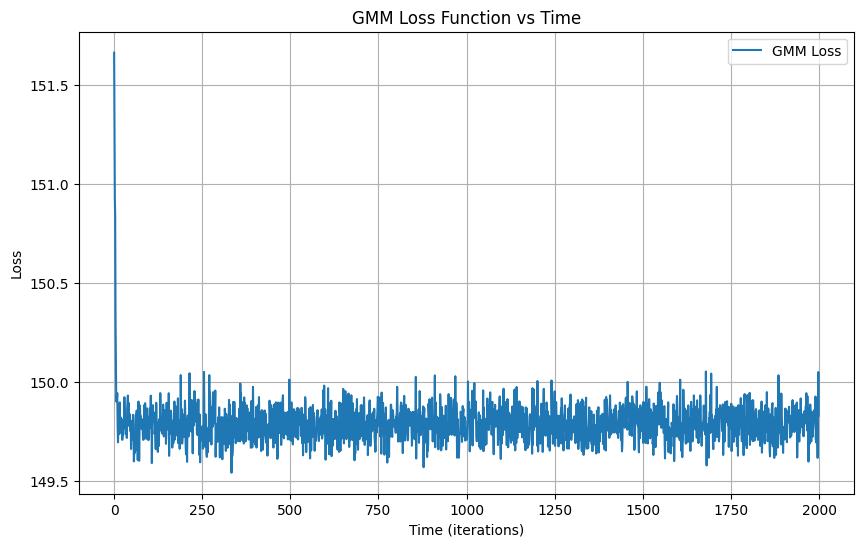

In [6]:
###Write your code here
n = 300
d = 150
k = 2
rho = 4
T = 2000
X, U_true, V_true = generate_gmm_data(n, d, k, rho)
Loss_history, Overlap_history, U, V  = gibbs_sampling(X, k, rho, U_true=U_true, V_true=V_true, T=T,  init='random')

plt.figure(figsize=(10, 6))
plt.plot(range(T), Loss_history, label='GMM Loss')
plt.xlabel('Time (iterations)')
plt.ylabel('Loss')
plt.title('GMM Loss Function vs Time')
plt.grid()
plt.legend()
plt.show()

In [7]:
Loss_history[-1]

np.float64(149.83086213642517)

**Question 3 (1 pt):** Store the values $U_{t}$ and $V_{t}$ during Gibbs sampling. Compute the overlap of the labels assignment with respect to the ground truth from the formula above.


Plot the Ovelap with respect to the Gibbs sampling iterations. Distinguish two cases, to show in the same plot:

1) Random initialization of $U_{t=0}$ and $V_{t=0}$ (in blue);

2) Informed initialization of $U_{t=0}=U^*$ and $V_{t=0}=V^*$ to the ground truth, i.e. $U_{t=0}$ and $V_{t=0}$ (in orange).

Important note : the ground truth is never known in practice and thus you simply cannot use it. For practical applications you always have to initialize randomly (blue curve). However, for the scope of the excercise and following what has been done in the tutorials, you can see the difference when initializing directly to the correct values (orange curve).

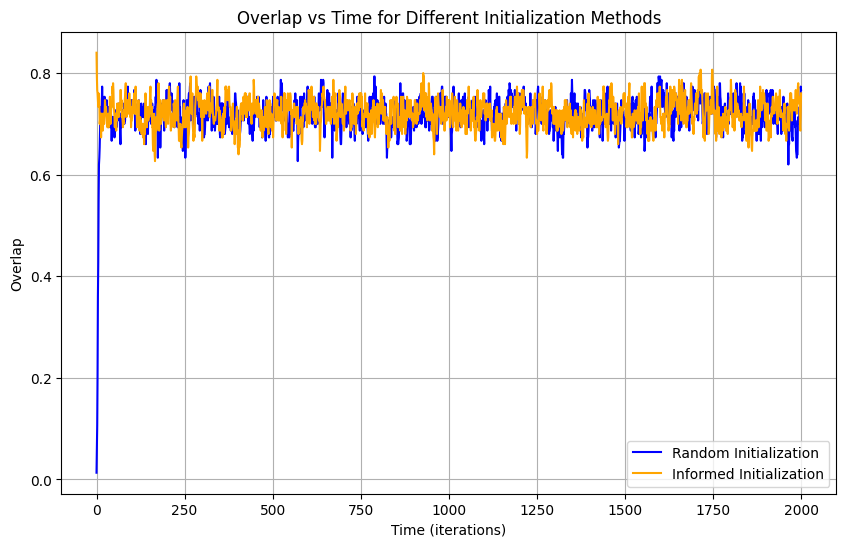

In [8]:
### Write your code here.
# Parameters
n, d, k = 300, 150, 2
T = 2000
rho = 4

# Generate data
X, U_true, V_true = generate_gmm_data(n, d, k, rho)

# Gibbs Sampling with random initialization
Loss_history_random, Overlap_history_random, U_random, V_random = gibbs_sampling(X, k, rho, U_true=U_true, V_true=V_true, T=T, init='random')

# Gibbs Sampling with informed initialization
Loss_history_informed, Overlap_history_informed, U_informed, V_informed = gibbs_sampling(X, k, rho, U_true=U_true, V_true=V_true, T=T, init='informed')

# Plot Overlap history for both initializations
plt.figure(figsize=(10, 6))
plt.plot(range(T), Overlap_history_random, label='Random Initialization', color="blue")
plt.plot(range(T), Overlap_history_informed, label='Informed Initialization', color="orange")
plt.xlabel('Time (iterations)')
plt.ylabel('Overlap')
plt.title('Overlap vs Time for Different Initialization Methods')
plt.grid()
plt.legend()
plt.show()


**Question 4 (1 pt):** Take $n=300$, $d=150$, $k=2$, $T = 1000$. Run Gibbs sampling with random initialization varying the parameter $\rho$ from 0 to 4 at steps of 0.1. For each value of rho, compute the mean overlap in the last steps (choose an appropriate value for convergence, same for T) and take also $n_{sim}=5$ different simulations in order to compute the standard deviation (in this question you are allowed to change the seed).

Plot the overlap with respect to the values of $\rho$ with error bars along the y-axis. Comment briefly the result.



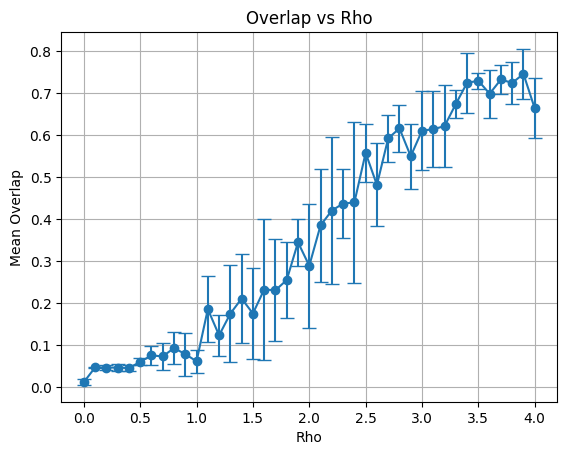

In [9]:
### Write your code here


# Parameters
n = 300
d = 150
k = 2
T = 1000
rho_values = np.arange(0, 4.1, 0.1)
n_sim = 5

overlap_means = []
overlap_stds = []

for rho in rho_values:
    overlaps = []
    for sim in range(n_sim):
        X, U_true, V_true = generate_gmm_data(n, d, k, rho)
        _, Overlap_history, _, _ = gibbs_sampling(X, k, rho, U_true=U_true, V_true=V_true, T=T, init='random')        
        overlaps.append(np.mean(Overlap_history[-100:]))
    
    overlap_means.append(np.mean(overlaps))
    overlap_stds.append(np.std(overlaps))


plt.errorbar(rho_values, overlap_means, yerr=overlap_stds, fmt='-o',label="Mean Overlap (with Error Bars)", capsize=5)
plt.xlabel('Rho')
plt.ylabel('Mean Overlap')
plt.title('Overlap vs Rho')
plt.grid(True)
plt.show()



As we can see, large $\rho$ increases the mean overlap, meaning that we are further aligning our predictions with the ground truth when the ration signal over noise is getting larger. Also, error bars show an improvement in stability with larger $\rho$, which indicates that the model is getting more consistent in identifying clusters as the noise is reduced.

**Question 5 (1 pt):** Now increase $n$ and $d$, in particular take $n=1500$, $d=1500$, $k=2$, $T=2000$, $\rho=3$. Compute and print the value of the overlap in two different ways:

1) Fit a K-means algorithm on the $X$ data, you can use existing libaries in sklearn. Compute the overlap between the original ground truth and the labels found by K-means.

2) with the previous Gibbs algorithm, just print the last value.



In both cases, run $n_{sim}=3$ simulations and print the two overlaps in the format $mean \pm std$.

Print these two values and compare them.


In [10]:
from sklearn.cluster import KMeans
np.random.seed(42) #fix this for reproducibility

### Write your code here
n,d,k,T,rho=1500,1500,2,2000,3
n_sim = 3

## Generate GMM data..
X, U_true, V_true = generate_gmm_data(n, d, k, rho)

gibbs_overlaps = []
kmeans_overlaps = []

for sim in range(n_sim):
    _, Overlap_history, _,_= gibbs_sampling(X, k, rho, U_true, V_true, T,  init='random')
    last_overlap = np.mean(Overlap_history[-1])
    gibbs_overlaps.append(last_overlap)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=sim)
    labels = kmeans.fit_predict(X)
    V_kmeans = np.zeros((n, k)) 
    V_kmeans[np.arange(n), labels] = 1
    overlap_kmeans = compute_overlap(V_kmeans, V_true, k)
    kmeans_overlaps.append(overlap_kmeans)

gibbs_mean_overlap = np.mean(gibbs_overlaps)
gibbs_std_overlap = np.std(gibbs_overlaps)

kmeans_mean_overlap = np.mean(kmeans_overlaps)
kmeans_std_overlap = np.std(kmeans_overlaps)

print(f"\nK-Means Overlap: Mean = {kmeans_mean_overlap:.4f}, Std = {kmeans_std_overlap:.4f}")
print(f"\nGibbs Sampling Overlap: Mean = {gibbs_mean_overlap:.4f}, Std = {gibbs_std_overlap:.4f}")


K-Means Overlap: Mean = 0.0720, Std = 0.0390

Gibbs Sampling Overlap: Mean = 0.4422, Std = 0.0267


_Answer_ : K-means seems to perform worse than the Gibbs sampling because the latter uses a probabilistic model suited for Gaussian distributions (indeed we chose a gaussian nature for the points), while K-means relies on distances, which fail in high dimensions (e.g., 1500). Moreover, while increasing the dimensions, we observe that the mean for Gibbs (around 0.43 instead of 0.6 for $\rho=3$) is lower due to high dimensionality reducing $\rho / d$, amplifying noise and making cluster separation harder since it is getting harder to distinguish well the points one to another.